In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math
%matplotlib inline

### Data preparation

In [2]:
def parse_csv(FolderName,FileName,DataPointEachFile):
    data=pd.read_csv(FolderName+FileName, header=None)
    rand_ind = np.random.randint(0,data.shape[1],DataPointEachFile)
    temperature_data = [data[4:][i].tolist() for i in rand_ind]
    birth_data = [data[3:4][i].values[0] for i in rand_ind]
    coordinate_data = [data[:3][i].tolist() for i in rand_ind]
    FileNameInfo = FileName.replace('.csv','').split('-')
    bulk_size=[list(map(int, FileNameInfo[:3])) for i in rand_ind]
    Laser_intensity= [int(FileNameInfo[3]) for i in rand_ind]
    return temperature_data,birth_data,coordinate_data,bulk_size,Laser_intensity

In [2]:
def parse_toolpath(FolderName,FileName,dt):
    toolpath_raw=pd.read_table(FolderName+FileName,delimiter=r"\s+",header=None, names=['time','x','y','z','state'])
    toolpath=[]
    state=[]
    time=0.0
    ind=0
    endTime = float(toolpath_raw.tail(1)['time'])
    while(time<=endTime):
        while(time>=toolpath_raw['time'][ind+1]):
            ind=ind+1
        X=toolpath_raw['x'][ind]+(toolpath_raw['x'][ind+1]-toolpath_raw['x'][ind])*(
            time-toolpath_raw['time'][ind])/(toolpath_raw['time'][ind+1]-toolpath_raw['time'][ind])
        Y=toolpath_raw['y'][ind]+(toolpath_raw['y'][ind+1]-toolpath_raw['y'][ind])*(
            time-toolpath_raw['time'][ind])/(toolpath_raw['time'][ind+1]-toolpath_raw['time'][ind])
        Z=toolpath_raw['z'][ind]+(toolpath_raw['z'][ind+1]-toolpath_raw['z'][ind])*(
            time-toolpath_raw['time'][ind])/(toolpath_raw['time'][ind+1]-toolpath_raw['time'][ind])
        toolpath.append([X,Y,Z])
        state.append(toolpath_raw['state'][ind+1])
        time = time +dt
    return toolpath, state, endTime

In [10]:
parse_csv('../Database/Data/20-20-10-800/','20-20-10-800.csv',10)

NameError: name 'parse_csv' is not defined

In [4]:
def extract_data(dataFolders,dataFiles,toolpathFiles,DataPoints):
    Global_dt = 0.1
    Global_temperature_data = []
    Global_birth_data = []
    Global_laser_intensity = []
    Global_laser_state = [] 
    Global_distance_feature = []
    Global_closest_wall = []
    Global_layer_height = []
    Global_end_time = []
    DataPointEachFile = int(DataPoints/len(dataFolders))
    for i in range(len(dataFolders)):
        # Getting information from csv file
        temperature_data,birth_data,coordinate_data,bulk_size,laser_intensity = parse_csv(dataFolders[i],dataFiles[i],
                                                                                          DataPointEachFile)
        # Getting information from toolpath file
        toolpath, state, endTime = parse_toolpath(dataFolders[i],toolpathFiles[i],Global_dt)
        
        # Arranging distance feature
        distance_feature = []
        for point in coordinate_data:
            dis_feature=[]
            for toolCoord in toolpath:
                r2=(point[0]-toolCoord[0])*(point[0]-toolCoord[0])+(point[1]-toolCoord[1])*(point[1]-toolCoord[1])+(
                    point[2]-toolCoord[2])*(point[2]-toolCoord[2])
                if r2>0.1:
                    dis = 1/r2
                else:
                    dis = 10
                dis_feature.append(dis)
            distance_feature.append(dis_feature)
        
        # Arranging closest wall feature
        closest_wall = []
        for point_index in range(len(coordinate_data)):
            closestWall = min(coordinate_data[point_index][0],coordinate_data[point_index][1],
                                bulk_size[point_index][0]-coordinate_data[point_index][0],
                                bulk_size[point_index][1]-coordinate_data[point_index][1])
            closest_wall.append(closestWall)
        
        # Arrange layer height feature
        layer_height = [point[2] for point in coordinate_data]
        
        # Arrange laser state feature
        laser_state = [state for point in coordinate_data]
        
        # Arrange end time
        end_time = [int(round(endTime/Global_dt)) for point in coordinate_data]
        
        # Arrange birth time
        birth_step = []
        for point_index in range(len(coordinate_data)):
            birth_step.append(math.floor(birth_data[point_index]/Global_dt))
        
        # Add information for each file to global variables
        Global_temperature_data += temperature_data
        Global_birth_data += birth_step
        Global_laser_intensity += laser_intensity
        Global_laser_state += laser_state 
        Global_distance_feature += distance_feature
        Global_closest_wall += closest_wall
        Global_layer_height += layer_height
        Global_end_time += end_time
        
        print("Data loaded from: "+ dataFolders[i])
        
    return (Global_temperature_data, Global_distance_feature, Global_laser_state, Global_birth_data, 
            Global_laser_intensity, Global_closest_wall, Global_layer_height, Global_end_time)

In [5]:
def history_plot(X):
    x = range(len(X))
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    ax.plot(x, X)
    ax.axis([0,len(X), min(X), 1.1*max(X)])
    plt.show()

In [6]:
def next_batch(temperature,distance,laser,birth,intensity,closest,layer,endtime,steps,batch_size):
    
    # Grab a random starting point for each batch
    rand_ind = np.random.randint(0,len(temperature),batch_size)
    rand_start_time = [np.random.randint(0,endtime[i]-steps) for i in rand_ind]
    temperature_batch = []
    distance_batch = []
    laser_batch = []
    start_batch = []
    birth_batch = []
    intensity_batch = [intensity[i] for i in rand_ind]
    closest_batch = [closest[i] for i in rand_ind]
    layer_batch = [layer[i] for i in rand_ind]
    
    for ind in range(len(rand_ind)):
        temperature_batch.append(temperature[rand_ind[ind]][rand_start_time[ind]:rand_start_time[ind]+steps])
        distance_batch.append(distance[rand_ind[ind]][rand_start_time[ind]:rand_start_time[ind]+steps])
        laser_batch.append(laser[rand_ind[ind]][rand_start_time[ind]:rand_start_time[ind]+steps])
        start_batch.append(temperature[rand_ind[ind]][rand_start_time[ind]])
        birth_batch.append(birth[rand_ind[ind]][rand_start_time[ind]:rand_start_time[ind]+steps])
    y_batch = np.array(temperature_batch).reshape(batch_size,steps,1)
    xt_batch = np.array([distance_batch,laser_batch,birth_batch]).transpose((1, 2, 0))
    xf_batch = np.array([start_batch,intensity_batch,closest_batch,layer_batch]).transpose((1,0))
    return y_batch, xt_batch, xf_batch

In [7]:
def next_batch_init(temperature,distance,laser,birth,intensity,closest,layer,endtime,steps,batch_size):
    
    # Grab a random starting point for each batch
    rand_ind = []
    for i in range(batch_size):
        while True:
            ran = np.random.randint(0,len(temperature))
            if birth[ran]+steps<len(temperature[ran]):
                rand_ind.append(ran)
                break
    temperature_batch = []
    distance_batch = []
    laser_batch = []
    birth_batch = []
    intensity_batch = [intensity[i] for i in rand_ind]
    closest_batch = [closest[i] for i in rand_ind]
    layer_batch = [layer[i] for i in rand_ind]
    
    for ind in range(len(rand_ind)):
        temperature_batch.append(temperature[rand_ind[ind]][birth[rand_ind[ind]]:steps+birth[rand_ind[ind]]])
        distance_batch.append(distance[rand_ind[ind]][birth[rand_ind[ind]]:steps+birth[rand_ind[ind]]])
        laser_batch.append(laser[rand_ind[ind]][birth[rand_ind[ind]]:steps+birth[rand_ind[ind]]])
    y_batch = np.array(temperature_batch).reshape(batch_size,steps,1)
    x_batch = np.array([distance_batch,laser_batch]).transpose((1, 2, 0))
    xf_batch = np.array([intensity_batch,closest_batch,layer_batch]).transpose((1,0))
    return y_batch, x_batch, xf_batch

In [8]:
def normalize_sequence(train_data,test_data):
    max_data=0.0
    min_data=1000
    for data in train_data:
        max_tem = max(data)
        min_tem = min(data)
        if max_tem>max_data:
            max_data=max_tem
        if min_tem<min_data:
            min_data=min_tem
        
        
    train_data_s=[[(train_data[i][j]-min_data)/(max_data-min_data) for j in range(len(train_data[i])
                                                                                 )] for i in range(len(train_data))]
    test_data_s=[[(test_data[i][j]-min_data)/(max_data-min_data) for j in range(len(test_data[i])
                                                                                 )] for i in range(len(test_data))]
    return train_data_s, test_data_s

def normalize_fixed(train_data,test_data):
    max_data=max(train_data)
    min_data=min(train_data)
    
    if max_data==min_data:
        return [1 for i in range(len(train_data))], [1 for i in range(len(test_data))]

    train_data_s=[(train_data[i]-min_data)/(max_data-min_data) for i in range(len(train_data))]
    test_data_s=[(test_data[i]-min_data)/(max_data-min_data) for i in range(len(test_data))]
    
    return train_data_s, test_data_s

### LSTM model setup

In [32]:
tf.reset_default_graph()
#Samples=['20-20-10-800','9-5-27-865','23-17-7-902','32-6-41-907','44-13-8-735']
Samples=['20-20-10-800','9-5-27-865']
dataFolders=['../Database/Data/'+sample+'/' for sample in Samples]
dataFiles=[sample+'.csv' for sample in Samples]
toolpathFiles=['toolpath.crs' for sample in Samples]
# Number of data points
DataPoints=100
# Version name
version_name="gru_100_multilayer_3_postmix"
# Num of steps in each batch
num_time_steps = 100
# Just one feature, the time series
num_inputs = 2
num_inputs_f = 3
# 100 neuron layer
num_neurons = 300
# Just one output, predicted time series
num_outputs = 1
# learning rate you can play with this
learning_rate = 0.0001
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 4000
# Size of the batch of data
batch_size = 20
# number of layers
num_layers = 3

In [10]:
temperature, distance, laser, birth, intensity, closest, layer, endtime =extract_data(dataFolders,dataFiles,
                                                                             toolpathFiles,DataPoints)

Data loaded from: ../Database/Data/20-20-10-800/
Data loaded from: ../Database/Data/9-5-27-865/


In [11]:
from sklearn.model_selection import train_test_split
(temp_train,temp_test,dis_train,dis_test,laser_train,laser_test,birth_train,birth_test,inten_train,inten_test,close_train,
                                     close_test,layer_train,layer_test,endtime_train,endtime_test) = train_test_split(
                                     temperature, distance, laser, birth, intensity, closest, layer,endtime,test_size=0.3,
                                     random_state=101)
temp_train_s,temp_test_s = normalize_sequence(temp_train,temp_test)
dis_train_s,dis_test_s = normalize_sequence(dis_train,dis_test)
laser_train_s,laser_test_s = normalize_sequence(laser_train,laser_test)
inten_train_s,inten_test_s = normalize_fixed(inten_train,inten_test)
close_train_s,close_test_s = normalize_fixed(close_train,close_test)
layer_train_s,layer_test_s = normalize_fixed(layer_train,layer_test)

In [33]:
X_f = tf.placeholder(tf.float32, [None, num_inputs_f],name="Feature_data_f")
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs],name="Feature_data")
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs],name="Temperature_output")

In [34]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [35]:
cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.GRUCell(num_units=num_neurons) for layer in range(num_layers)])
outputs, states = tf.nn.dynamic_rnn(cell, X ,dtype=tf.float32)

In [36]:
W = tf.get_variable('W', [num_neurons,num_outputs])
b = tf.get_variable('b', [num_outputs], initializer=tf.constant_initializer(0.0))
outputs = tf.reshape(outputs, [-1, num_neurons])
output = tf.matmul(outputs, W)+b
output = tf.reshape(output,[-1,num_time_steps])
output = tf.concat([output,X_f],1)

In [38]:
full_one = normal_full_layer(output, num_time_steps)
full_two = normal_full_layer(full_one, num_time_steps)
final_output = tf.reshape(full_two,[-1,num_time_steps,num_outputs])

In [42]:
with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.abs(final_output - y)) #MAE
    tf.summary.scalar('loss',loss)
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train = optimizer.minimize(loss)

In [43]:
init = tf.global_variables_initializer()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)
saver = tf.train.Saver()
y_test, X_test, X_f_test = next_batch_init(temp_test_s,dis_test_s,laser_test_s,birth_test,inten_test_s,
                                                      close_test_s,layer_test_s,endtime_test,num_time_steps,len(temp_test_s))

0 	MAE_Train: 0.252915 	MAE_Test: 0.202034
100 	MAE_Train: 0.101521 	MAE_Test: 0.0923986
200 	MAE_Train: 0.0611896 	MAE_Test: 0.0624208
300 	MAE_Train: 0.043075 	MAE_Test: 0.0439785
400 	MAE_Train: 0.0275893 	MAE_Test: 0.0373106
500 	MAE_Train: 0.0291953 	MAE_Test: 0.0351836
600 	MAE_Train: 0.0259094 	MAE_Test: 0.0328161
700 	MAE_Train: 0.022328 	MAE_Test: 0.033012
800 	MAE_Train: 0.023092 	MAE_Test: 0.0314182
900 	MAE_Train: 0.0249079 	MAE_Test: 0.0320666
1000 	MAE_Train: 0.0254734 	MAE_Test: 0.0309445
1100 	MAE_Train: 0.022958 	MAE_Test: 0.0316659
1200 	MAE_Train: 0.0221498 	MAE_Test: 0.0302714
1300 	MAE_Train: 0.0230484 	MAE_Test: 0.030383
1400 	MAE_Train: 0.0249786 	MAE_Test: 0.0297406
1500 	MAE_Train: 0.0185474 	MAE_Test: 0.0305512
1600 	MAE_Train: 0.0194356 	MAE_Test: 0.0290772
1700 	MAE_Train: 0.0226784 	MAE_Test: 0.0298521
1800 	MAE_Train: 0.0252948 	MAE_Test: 0.029505
1900 	MAE_Train: 0.0240975 	MAE_Test: 0.0291444
2000 	MAE_Train: 0.0181678 	MAE_Test: 0.0292765
2100 	MAE_Trai

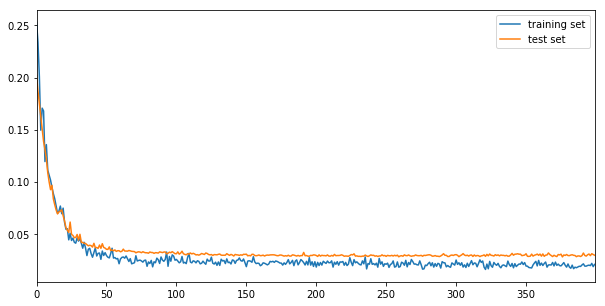

In [44]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    mse_train=[]
    mse_test=[]
    #merged_summary=tf.summary.merge_all()
    #writer = tf.summary.FileWriter("./tensorboard_"+version_name)
    #writer.add_graph(sess.graph)
    #summaries = tf.summary.merge_all()
    for iteration in range(num_train_iterations):
        y_batch, X_batch, X_f_batch = next_batch_init(temp_train_s,dis_train_s,laser_train_s,birth_train,inten_train_s,
                                                      close_train_s,layer_train_s,endtime_train,num_time_steps,batch_size)
        sess.run(train, feed_dict={X_f:X_f_batch , X: X_batch, y: y_batch})
        if iteration % 10 ==0:
            #s=sess.run(merged_summary,feed_dict={X: X_batch, y: y_batch})
            #writer.add_summary(s,iteration)
            mse_tr=loss.eval(feed_dict={X_f:X_f_batch, X: X_batch, y: y_batch})
            mse_te=loss.eval(feed_dict={X_f:np.array(X_f_test), X: np.array(X_test), y: np.array(y_test)})
            mse_train.append(mse_tr)
            mse_test.append(mse_te)
        if iteration % 100 == 0:
            print(iteration, "\tMAE_Train:", mse_tr,"\tMAE_Test:", mse_te)
    # Plot training progress
    train_trend = pd.concat([pd.DataFrame(data=mse_train,columns=['training set']),pd.DataFrame(data=mse_test,columns=['test set'])],axis=1)
    train_trend.plot(figsize=(10,5))
    train_trend.to_csv(version_name+'.csv', index=False, header=False)
    # Save Model for Later
    saver.save(sess, "Models/"+version_name)
    #writer.close()

### Utilization and testing

In [26]:
len(temp_test_s)

300

INFO:tensorflow:Restoring parameters from Models/gru_100_multilayer_3_postmix


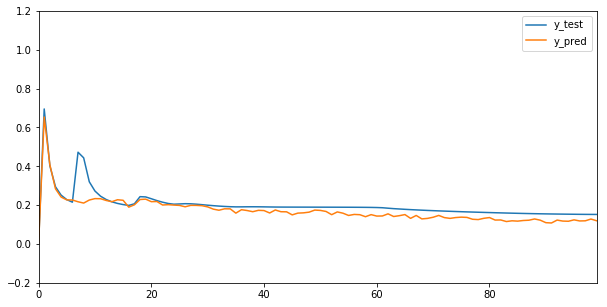

In [54]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "Models/"+version_name)
    y_batch, X_batch, X_f_batch = next_batch_init(temp_train_s,dis_train_s,laser_train_s,birth_train,inten_train_s,
                                                  close_train_s,layer_train_s,endtime_train,num_time_steps,1)
    y_pred = sess.run(final_output, feed_dict={X: X_batch, X_f:X_f_batch})
    data = pd.concat([pd.DataFrame(data=y_batch.flatten(),columns=['y_test']),
                      pd.DataFrame(data=y_pred.flatten(),columns=['y_pred'])],axis=1)
data.plot(figsize=(10,5),ylim=(-0.2,1.2))